In [1]:
from utils import reactjs
reactjs.css()

![washington](./cropping-3-python-hero-image.jpg)

## The problem of cropping
Cropping of images is often one of the last things to do before publishing an
article. We have to finalise all images and text content before knowing how much
space to use for each component and how it all fits together.
h
In digital publishing, the same images are often reused in a multitude of shapes
and sizes for different channels. A typical blog post or news article will have
a main article view. But in a responsive page layout, the images often will have
different shapes on different screen sizes. With a website redesign, legacy
content might also have to be converted to a new layout in bulk. That could
involve a new shape for primary and supporting images. There's section front
pages, search result pages, «related content»-teasers and social media previews.
Many of these layouts require that images must be cropped into a specific shape.

Even a human designer or editor is doing the image cropping manually, it can be
difficult to know which parts of a photo to crop away and which parts to keep.

### An Algorithm of Aesthetics
When there's a large set of images that must be cropped, it's sometimes
unfeasible to manually decide how to best crop each individual photo. Instead we
can use an automated process to classify images and determine which features and
point of interest that is most important, and as a consequence, which sections
of the image that are less interesting.

In this article I'll show how we can use the open source OpenCV computer vision
library and the Python programming language to analyze photos to automate image
cropping.

* Existing solutions
    * cropping as a service
        https://github.com/thumbor/thumbor
    
* What I want
    * self-contained
    * flexible
    * tweakable

## The Open Source Computer Vision library
OpenCV is a very large library of tools and algoritms for computer vision. It's
written in C++ and has bindings for Java, C++ and Python. Like many other
scientific packagages that are written by and for academics and scientist, the
documentation and the apis can be somewhat hard to understand without the
relevant academic background.

Installing OpenCV is also much less straightforward than your typical python
package. To use the latest version with python 3 support you have to install a
lot of supporting libraries and configure and build OpenCV itself using cmake.
There are also prebuilt versions available for some versions and operating
systems. I found the [installation guides at pyimagesearch.com][install] very helpful when
to get opencv3.0 and python3.5 bindings installed on ubuntu.

The OpenCV library gives you a very large toolbox of algorithms for doing all
sorts of computer vision, video and image analysis. In this article I'm just
going to use two of them: The [ORB] keypoint detector and descriptor extractor and
the [Viola-Jones] object detection framework (Haar Cascade Classifier).

When reading the OpenCV documentation, you'll run into a lot of academic terms
like "Haar Cascade" and acronyms such as BRIEF (Binary Robust Independent
Elementary Features). All of these are described in various scientific papers,
and to really undestand how the algorithms work takes a lot of effort. The good
news is that you don't really have to understand how everything works to be able
to actually use OpenCV. A good place to find beginner friendly tutorials is
[pyimagesearch.com].

[install]: http://www.pyimagesearch.com/2015/07/20/install-opencv-3-0-and-python-3-4-on-ubuntu/
[Viola-Jones]: https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework
[ORB]: https://en.wikipedia.org/wiki/ORB_(feature_descriptor)
[pyimagesearch.com]: http://pyimagesearch.com

* Specific libraries:
    * Haar-cascade classifiers
    http://docs.opencv.org/3.1.0/d7/d8b/tutorial_py_face_detection.html#gsc.tab=0
    https://en.wikipedia.org/wiki/Viola%E2%80%93Jones_object_detection_framework
    * ORB feature detection
    https://en.wikipedia.org/wiki/ORB_(feature_descriptor)
    http://docs.opencv.org/3.0-beta/doc/py_tutorials/py_feature2d/py_orb/py_orb.html

### Playing around with OpenCV in Jupyter
Since OpenCV is a computer _vision_ library, you can play around with images and

algorithms and get quick visual results. Algorithms such as Viola-Jones and ORB
are optimized for speed so that they can be used for real time video. Thus they
are can also process static images very fast.

Whenever I want to learn a new python library, I  use [Jupyter
notebooks] to do some exploratory programming. This is also a tool
that is used a lot in academia and science, since it's very well suited for
exploring data and sharing code.

Jupyter can also be used to edit markdown. In fact this blog post is written in
jupyter (you can see the source [here][source]).

The apis and output data structures in OpenCV do not seem to follow any common
structure, so for a python programmer it can be quite confusing to use. Since I
want to use both Viola-Jones (`cv2.CascadeClassifier`) and ORB
(`cv2.ORBClassifier`) to detect salient features or points of interest in images.

[source]: https://github.com/haakenlid/hken.no/blob/master/pages/blog/cropping-3-python/index.ipynb
[Jupyter notebooks]: http://jupyter.org

## Feature detector interface 

Since the OpenCV apis are complex and each algorithm is implemented differently, we'll create some wrapper classes that presents a uniform interface. This would be an example of the Facade or Adapter design pattern. 

We'll start by defining a base class that defines the interface that all the detectors will use. To make it more explicit we'll define it as an Abstract Base Class, using the standard library `abc` module. I'm also using type annotations, which is a fairly new feature in python 3.

In [2]:
import abc   # abstract base classes
from typing import List  # type annotations
from utils.cropengine import Feature  # I'll explain this one soon.

FileName = str  # type alias

class FeatureDetector(abc.ABC):
    """Abstract base class for the feature detectors."""

    @abc.abstractmethod
    def detect_features(self, fn: FileName) -> List[Feature]:
        """Find the most salient features of the image."""
        ...
        

All our feature detector classes will be subclasses of `FeatureDetector` and must override the `detect_features` method, using the same method signature.

### Input data

Here's the function we'll use to prepare image files for image analyzis. The function reads an image file and optionally resamples it to a standard image size. This is useful for normalizing images to a standard size, as well as for performance. 

In [3]:
import cv2    # The opencv python bindings
import numpy  # Python scienticic computing library

# OpenCv represents all images as n-dimensional numpy arrays.
# For clarity and convenience, we'll just call it "CvImage"
CVImage = numpy.ndarray

def opencv_image(fn: str, resize: int=0) -> CVImage:
    """Read image file to grayscale openCV int array.

    The OpenCV algorithms works on a two dimensional
    numpy array integers where 0 is black and 255 is
    white. Color images will be converted to grayscale.
    """
    cv_image = cv2.imread(fn)
    cv_image = cv2.cvtColor(
        cv_image, cv2.COLOR_BGR2GRAY)
    if resize > 0:
        w, h = cv_image.shape[1::-1]  # type: int, int
        multiplier = (resize ** 2 / (w * h)) ** 0.5
        dimensions = tuple(
            int(round(d * multiplier)) for d in (w, h))
        cv_image = cv2.resize(
            cv_image, dimensions,
            interpolation=cv2.INTER_AREA)
    return cv_image

def resize_feature(feature: Feature, cv_image: CVImage) -> Feature:
    """Convert a Feature to a relative coordinate system.

    The output will be in a normalized coordinate system
    where the image width and height are both 1.
    Any part of the Feature that overflows the image
    frame will be truncated.
    """
    img_h, img_w = cv_image.shape[:2]  # type: int, int
    feature = Feature(
        label=feature.label,
        weight=feature.weight / (img_w * img_h),
        left=max(0, feature.left / img_w),
        top=max(0, feature.top / img_h),
        right=min(1, feature.right / img_w),
        bottom=min(1, feature.bottom / img_h),
    )
    return feature



Let's try this function on an example image. First we use a utility function `show_image` to display the source image. Then, we'll convert it to a very low resolution numpy array, and then we'll convert the array back to an image format, so we can compare with the original.

In [4]:
from utils import display
example_image = './monkey-race-wide.jpg'
display.show_image(example_image)


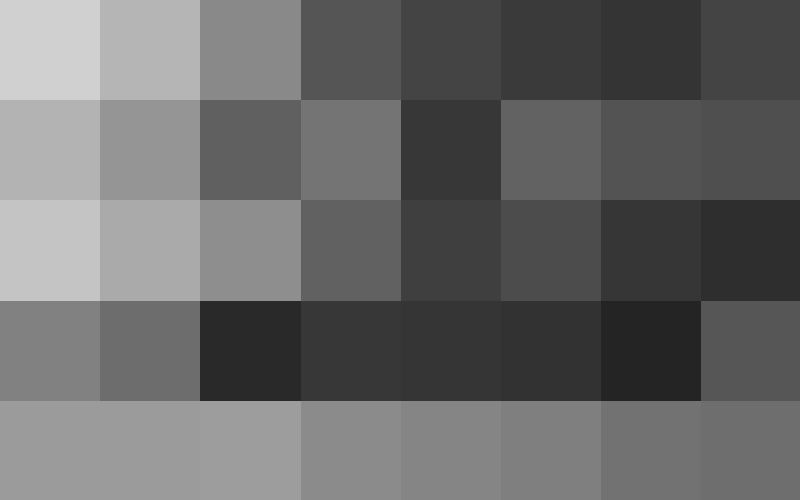

In [5]:
img_array = opencv_image(example_image, 6)
display.show_image(img_array) # convert to png and display

Let's see what the raw numpy array looks like.

In [6]:
img_array # This is the data type that opencv uses.

array([[208, 181, 137,  85,  68,  58,  52,  68],
       [179, 149,  96, 116,  55,  98,  83,  79],
       [196, 170, 142,  97,  63,  76,  54,  46],
       [129, 109,  41,  55,  53,  50,  36,  86],
       [155, 155, 157, 139, 133, 127, 114, 110]], dtype=uint8)

When we prepare the image for a computer vision algorithm, we'll try to find the smallest input size that still gives us acceptable results. Shrinking the input image can save a lot of execution time, but at some point, downsampling will result in low quality output from the algorithms. In this case, there's not much useful data left from the original image.

### Output data
We know what the input looks like, let's figure out what output data we expect from our feature detector. 
To make the output portable, we'll ultimately store and transmit it in json format. It will be an array of objects.

In [7]:
# This is what the json data looks like. 
# Conveniently it's also valid python code.
data = [
  {
    "label": "keypoint one",
    "x": 0.25,
    "y": 0.25,
    "width": 0.30,
    "height": 0.50,
    "weight": 2
  },
  {
    "label": "keypoint two",
    "x": 0.20,
    "y": 0.20,
    "width": 0.15,
    "height": 0.25,
    "weight": 1
  }
]

Each feature is represented as a rectangle in a coordinate system where (0, 0) is the upper left corner of the image and (1, 1) is the lower right corner of the image. This is convenient since we are going to use this data to render html and svg graphics.

* `label` is a string that will be used as a css class for the feature, so we can distinguish various types of features.
* `x` and `y` are the coordinates of the upper left corner of the feature
* `weight` is a quantity representing the relative importance or saliency of a given feature.

To visualize these feature, we'll use reactjs and node to create a svg and html widget. 

In [8]:
from utils.reactjs import render  
# Renders the widget with react, redux and node.js
features = [Feature.deserialize(item) for item in data]
render(example_image, features)

As you can see, the `Feature` class can be serialized and deserialized, which makes it possible to convert to json and back. In addition, the class implements implements some dunderscore methods, such as `__add__`,  `__mul__` and `__and__` so that we can perform operations using the built-in operators `+`, `*`, `&` etc. 

Multiplication will change the size and weight of the Feature, but the center point and label will not change.

In [9]:
features[0] * 0.4

Feature(top=0.4, left=0.34, right=0.46, weight=0.8, bottom=0.6, label='keypoint one')

Adding two features together will give us a new Box that circumscribes both features.

In [10]:
features[0] + features[1]

Box(bottom=0.75, left=0.2, right=0.55, top=0.2)

The `&` operator will return a Box that is the intersection of the two operand features.

In [11]:
features[0] & features[1]

Box(bottom=0.45, left=0.25, right=0.35, top=0.25)

### Putting it together
For convenience we'll add two useful static methods to the `FeatureDetector` class 

In [12]:
FeatureDetector._opencv_image = staticmethod(opencv_image)
FeatureDetector._resize_feature = staticmethod(resize_feature)

Let's make an actual feature detector class. We'll not use any computer vision algoritms. Instead we'll just return some mock features. The widget sort of resembles a gun sight, so why not let it look even more so.

In [13]:
class MockFeatureDetector(FeatureDetector):

    """Example feature detector interface."""
    
    def __init__(self, n: int=3, size: int=200) -> None:
        self._number = n
        self._size = size

    def detect_features(self, fn: FileName) -> List[Feature]:
        """Concentric features at center of the image"""
        cv_image = self._opencv_image(fn, 200)
        img_h, img_w = cv_image.shape[:2]  
        middle = Feature(1, 'mock keypoint', 0, 0, img_w, img_h)
        middle.width = middle.height = min(img_w, img_h)
        middle = self._resize_feature(middle, cv_image)
        middle.weight = 10
        num = self._number
        sizes = ((num - m) / num for m in range(num))
        return [middle * size for size in sizes]

detector = MockFeatureDetector(5)
render(example_image, detector.detect_features(example_image))

Excellent. But still quite useless. Let's try to use an actual computer vision algorithm to find some real features. 

## Keypoint detector
* What is ORB?
* link to documentation

### Code

In [14]:
class KeypointDetector(FeatureDetector):

    """Feature detector using OpenCVs ORB algorithm"""

    CSS_CLASS_NAME = 'ORB keypoint'

    def __init__(self, n: int=10, padding: float=1.0,
                 imagesize: int=200, **kwargs) -> None:
        self._imagesize = imagesize
        self._padding = padding
        _kwargs = {
            "nfeatures": n + 1,
            "scaleFactor": 1.5,
            "patchSize": self._imagesize // 10,
            "edgeThreshold": self._imagesize // 10,
            "WTA_K": 2,
            "scoreType": cv2.ORB_FAST_SCORE,
        }
        _kwargs.update(kwargs)
        self._detector = cv2.ORB_create(**_kwargs)

    def detect_features(self, fn: str) -> List[Feature]:
        """Find interesting keypoints in the image."""
        features = []
        cv_image = self._opencv_image(fn, self._imagesize)
        keypoints = self._detector.detectAndCompute(
            image=cv_image, mask=None)[0]

        for keypoint in keypoints:
            x, y = keypoint.pt  # type: float, float
            radius = keypoint.size / 2  # type: float
            weight = radius * keypoint.response ** 2
            feature = Feature(
                label=self.CSS_CLASS_NAME,
                weight=weight,
                left=x - radius,
                top=y - radius,
                right=x + radius,
                bottom=y + radius
            )
            feature = feature * self._padding
            feature = self._resize_feature(feature, cv_image)
            features.append(feature)

        return sorted(features, reverse=True)


### Output

In [15]:
detector = KeypointDetector()
example_image = './Henri-Cartier-Bresson-Hyeres-France-1932.jpg'
render(example_image, detector.detect_features(example_image))

* discussion

## Face detection
* What are Haas-cascades?

### Code

In [16]:
import os
class Cascade:

    """Wrapper for Haar cascade classifier"""

    _DIR = '/usr/share/opencv/haarcascades/'

    def __init__(self, label: str, fn: FileName,
                 size: float=1, weight: float=100) -> None:
        self.label = label
        self.size = size
        self.weight = weight
        self._file = os.path.join(self._DIR, fn)
        self.classifier = cv2.CascadeClassifier(self._file)


class FaceDetector(FeatureDetector):

    """Face detector using OpenCVs Viola-Jones algorithm and
    and Haar cascade training data files classifying human
    frontal and profile faces."""

    _CASCADES = [
        Cascade('frontal face',
                'haarcascade_frontalface_default.xml',
                size=1.0, weight=100),
        Cascade('alt face',
                'haarcascade_frontalface_alt.xml',
                size=1.2, weight=100),
        Cascade('profile face',
                'haarcascade_profileface.xml',
                size=0.9, weight=50),
    ]

    def __init__(self, n: int=10, padding: float=1.2,
                 imagesize: int=600, **kwargs) -> None:
        self._number = n
        self._imagesize = imagesize
        self._padding = padding
        self._cascades = self._CASCADES
        minsize = max(25, imagesize // 20)
        self._kwargs = {
            "minSize": (minsize, minsize),
            "scaleFactor": 1.2,
            "minNeighbors": 5,
        }
        self._kwargs.update(kwargs)

    def detect_features(self, fn: FileName) -> List[Feature]:
        """Find faces in the image."""
        features = []  # type: List[Feature]
        cv_image = self._opencv_image(fn, self._imagesize)

        for cascade in self._cascades:
            padding = self._padding * cascade.size
            detect = cascade.classifier.detectMultiScale
            faces = detect(cv_image, **self._kwargs)

            for left, top, width, height in faces:
                weight = height * width * cascade.weight
                face = Feature(
                    label=cascade.label,
                    weight=weight,
                    left=left,
                    top=top,
                    right=left + width,
                    bottom=top + height,
                )
                face = face * padding
                face = self._resize_feature(face, cv_image)
                features.append(face)

        return sorted(features, reverse=True)[:self._number]



### Output

In [17]:
detector = FaceDetector()
example_image = './Henri-Cartier-Bresson-Alicante-1932.jpg'
render(example_image, detector.detect_features(example_image))

* discussion

## Combined feature detector
* explanation

### Code

In [18]:
class HybridDetector(FeatureDetector):

    """Detector using a hybrid strategy to find salient
    features in images.

    Tries to detect_features faces first. If the faces are
    small relative to the image, will detect_features
    keypoints as well.  If no faces are detected, will fall
    back to a pure KeypointDetector."""

    BREAKPOINT = 0.15

    def __init__(self, n=10) -> None:
        self.primary = FaceDetector(n)
        self.fallback = KeypointDetector(n)
        self.breakpoint = self.BREAKPOINT
        self._number = n

    def detect_features(self, fn: FileName) -> List[Feature]:
        """Find faces and/or keypoints in the image."""
        faces = self.primary.detect_features(fn)
        if faces and sum(faces).size > self.breakpoint:
            return faces
        features = faces + self.fallback.detect_features(fn)
        return features[:self._number]


### Output

In [19]:
detector = HybridDetector()
example_image = './Gordon-Parks-New-York-1958.jpg'
render(example_image, detector.detect_features(example_image))

* discussion

## Summary
* it's easy!
* links
    * OpenCV guy
    * documentation
    * sorl-thumbnail
* My own stuff
    * Algorithm
    * React component

In [20]:
images = [
    'Sebastiao-Salgado-Serra-Pelada-1986.jpg',
    'Henri-Cartier-Bresson-Ann-Arbor-1960.jpg',
    'Henri-Cartier-Bresson-Dessau-1945.jpg',
    'Henri-Cartier-Bresson-Hyeres-France-1932.jpg',
    'Marc-Riboud-Washington-1967.jpg',
    'Gordon-Parks-New-York-1958.jpg',
]
display.croppify_all(detector, images, preview=True)

In [21]:
import importlib
modules = 'logging numpy cv2 os xml PIL curses shutil mimetypes urllib http'.split()

for module_name in modules:
    m = importlib.import_module(module_name)
    print('{:10}{:4}'.format(m.__name__, len(dir(m))))

logging    100
numpy      599
cv2       1481
os         333
xml         10
PIL         30
curses     298
shutil      67
mimetypes   29
urllib      10
http        12
